# Lehmann Benchmark – Implicit FD scheme with Picard linerisation method

This notebook solves the **1D Richards’ Equation** using implicit finite difference methods (Picard iterations) for the **Lehmann et al. (1998)** infiltration benchmark.

## Governing Equation ($\psi$-based form of Richards’ Equation):
$
C(\psi)\frac{\partial \psi}{\partial t} = \frac{\partial}{\partial z}\left[K(\psi)\left(\frac{\partial \psi}{\partial z} - 1\right)\right]
$
- $\psi$: pressure head [cm]
- $C(\psi)$: specific moisture capacity [1/cm]
- $K(\psi)$: hydraulic conductivity [cm/s]

**Soil model:** van Genuchten–Mualem, parameters below.  
**Domain:** 180 cm depth (Δz = 2.0 cm)  
**Time:** up to 60 days, test Δt = 1 day  
**BCs:** daily rainfall time-series top BC, Free drainage bottom BC  
**IC:** ψ = –10000 cm (very dry initial condition)

## ⚠️ Important Note

If using Google Colab, **the Newton-based scheme may fail due to matrix singularity** unless the environment is updated or regularised. This model is known to **work fine in Jupyter**.

---


# INPUT SECTION

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# --- Rainfall-Evaporation Input Time Series ---
# This array represents a synthetic or measured time series of net water fluxes (rainfall - evaporation),
# already converted into units of cm/day
values = [
    0.   ,  1.   ,  0.6  ,  0.8  ,  0.5  ,  0.1  ,  0.3  ,  0.6  ,
    0.7  ,  0.4  , -0.1  , -0.05 , -0.1  , -0.15 , -0.05 , -0.14 ,
   -0.05 ,  0.   , -0.05 , -0.07 , -0.05 , -0.04 , -0.01 , -0.03 ,
   -0.005, -0.03 , -0.04 , -0.02 , -0.01 , -0.005,  0.   ,  0.   ,
    0.   ,  0.   ,  0.8  ,  1.5  ,  0.5  ,  0.7  , -0.18 , -0.16 ,
   -0.05 , -0.05 , -0.1  , -0.04 , -0.02 , -0.005, -0.01 , -0.005,
   -0.005, -0.05 , -0.1  ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
    0.   ,  0.8  ,  1.4  ,  1.2
]
rain_evap = np.array(values)  # Convert to NumPy array
rain_evap  # This is already in cm/day

# --- Soil Hydraulic Parameters (Glendale Clay Loam) ---
# van Genuchten–Mualem model parameters and specific storage
def setpars():
    pars = {}
    pars['thetaR'] = 0.1060      # Residual water content [-]
    pars['thetaS'] = 0.4686      # Saturated water content [-]
    pars['alpha']  = 0.0104      # Inverse air-entry suction [1/cm]
    pars['m']      = 0.28336     # Shape parameter m = 1 - 1/n
    pars['n']      = 1.3954      # Shape parameter n
    pars['Ks']     = 13.1        # Saturated hydraulic conductivity [cm/day]
    pars['Ss']     = 1e-6        # Specific storage [1/cm] for unconfined aquifer terms
    return pars

pars = setpars()  # Load the soil parameters into dictionary `pars`

# --- Time Discretization ---
qT = rain_evap * -1        # Top flux [cm/day], inverted sign: infiltration (+) is downward
t = np.arange(len(qT))     # Time array [days]
dt = 1                     # Time step [day]
nt = len(t)                # Number of time steps

# --- Spatial Discretization (1D Soil Column) ---
dz = 2                    # Spatial step [cm]
zN = 180                  # Total column depth [cm]
z = np.arange(dz, zN, dz) # Spatial grid from dz to zN (exclusive), so depth excludes surface node
n = len(z)                # Number of spatial nodes

# --- Initial Condition ---
psi = np.zeros((nt, n))     # Create 2D array of pressure head ψ (time x depth)
psi[0, :] = -10000          # Initial pressure head: very dry soil [-10000 cm]

# MODEL SET UP

In [ ]:
# Define Van Genuchten water retention model and derivatives

def Cfun(psi, pars):
    """
    Specific moisture capacity C(ψ) = dθ/dψ.
    - Captures how water content changes with pressure head.
    - Uses the derivative of the van Genuchten water retention curve.
    - When ψ ≥ 0 (saturated conditions), returns specific storage Ss for stability.
    """
    α, n, m = pars['alpha'], pars['n'], pars['m']
    θs, θr  = pars['thetaS'], pars['thetaR']
    Ss      = pars['Ss']

    x3 = 1 + (α * np.abs(psi))**n
    x2 = x3**(m + 1)
    x1 = α * n * m * (α * np.abs(psi))**(n - 1) / x2

    return np.where(psi >= 0, Ss, (θs - θr) * x1)

def Kfun(psi, pars):
    """
    Unsaturated hydraulic conductivity K(ψ) using Mualem–van Genuchten formula.
    - Returns Ks under saturated conditions (ψ ≥ 0).
    """
    α, n, m, Ks = pars['alpha'], pars['n'], pars['m'], pars['Ks']

    x6 = 1 + (α * np.abs(psi))**n
    x5 = x6**(m * 0.5)
    x4 = (α * np.abs(psi))**(n - 1) * x6**(-m)
    x3 = 1 - x4
    x2 = x3**2
    x1 = x2 / x5

    return np.where(psi >= 0, Ks, Ks * x1)

def thetafun(psi, pars):
    """
    Volumetric water content θ(ψ) based on van Genuchten model.
    - Returns θs when ψ ≥ 0 (saturated zone).
    """
    α, n, m = pars['alpha'], pars['n'], pars['m']
    θs, θr  = pars['thetaS'], pars['thetaR']

    x3 = 1 + (α * np.abs(psi))**n
    x2 = x3**m
    x1 = (θs - θr) / x2

    return np.where(psi >= 0, θs, θr + x1)

# Define matrix solver for Picard iteration of ψ-based Richards Equation

def solverfun(R, C, Kmid, dt, dz, n):
    """
    Solves the linear system A·δ = R to update pressure head in each Picard iteration.
    - R: Residual vector
    - C: Specific moisture capacity
    - Kmid: Arithmetic average of K at interfaces
    """

    # Initialize tridiagonal matrix components
    a = np.zeros(n)  # Lower diagonal
    b = np.zeros(n)  # Main diagonal
    c = np.zeros(n)  # Upper diagonal
    y = np.zeros(n)  # Right-hand side

    # Fill matrix diagonals (internal nodes)
    a = -Kmid[:-1] / dz
    b = (Kmid[:-1] + Kmid[1:]) / dz + C * dz / dt
    c = -Kmid[1:] / dz

    # Modify boundary diagonals
    b[0] = Kmid[1] / dz + C[0] * dz / dt      # Bottom boundary (Neumann)
    b[-1] = Kmid[-2] / dz + C[-1] * dz / dt   # Top boundary (flux)

    # Assemble sparse tridiagonal matrix
    A = np.diag(a[1:], -1) + np.diag(b, 0) + np.diag(c[:-1], 1)

    # RHS vector is residual R
    y[:] = R[:]

    # Solve linear system for δ = ψ_{new} - ψ_{old}
    dell = np.linalg.solve(A, y)
    # ⚠️ WARNING: This solve step may fail in Colab if the matrix A is singular
    # Consider using Jupyter or a more robust Colab kernel
    return dell

def Rfun(psiiter, psiin, qT, KB, C, Kmid, dt, dz, n):
    """
    Computes residual R in Picard iteration:
    R = Mass accumulation + flux divergence
    - psiin: pressure head at time n
    - psiiter: current iteration of pressure head at time n+1
    - qT: flux boundary at the surface
    - KB: bottom boundary flux value
    """

    zero = np.array([0])  # dummy value for ghost cells (boundary padding)
    psigrid = np.hstack((zero, psiiter, zero))  # Add ghost nodes

    # Accumulation term (transient water content)
    x1 = -C * (psiiter - psiin) / dt * dz

    # Conductive flux divergence using harmonic averaging of K
    x2 = (Kmid[1:] - Kmid[:-1])                   # gradient of K
    x3 = Kmid[1:] * (psigrid[2:] - psigrid[1:-1]) / dz  # top flux
    x4 = -Kmid[:-1] * (psigrid[1:-1] - psigrid[:-2]) / dz  # bottom flux

    # Apply boundary conditions
    x2[0] = Kmid[1]       # Lower BC: no flux gradient
    x4[0] = -KB           # Replace with inflow K

    x2[-1] = -Kmid[-2]    # Upper BC: no gradient
    x3[-1] = -qT          # Surface flux boundary

    R = x1 + x2 + x3 + x4

    return R


def iterfun(psiin, pars, qT, dt, dz, n):
    """
    Picard iterative loop to solve the nonlinear system:
    ψ^{n+1,m+1} = ψ^{n+1,m} + δ
    - psiin: solution at time step n
    - psiout: updated solution at time n+1 after convergence
    """

    tolerance = 1e-10         # convergence threshold
    maxcount = 10000          # max iterations
    zero = np.array([0])      # ghost node padding

    # Initialise iteration arrays
    psiiter = psiin.copy()    # initial guess
    psiout = np.zeros_like(psiin)

    count = 0
    while count <= maxcount:
        # Evaluate moisture capacity C and hydraulic conductivity K
        C = Cfun(psiiter, pars)
        K = Kfun(np.hstack((zero, psiiter, zero)), pars)
        Kmid = (K[1:] + K[:-1]) / 2  # interface conductivities

        # Compute residual
        R = Rfun(psiiter, psiin, qT, K[1], C, Kmid, dt, dz, n)

        # Solve for update δ
        dell = solverfun(R, C, Kmid, dt, dz, n)

        # Update pressure
        psiout = psiiter + dell
        psiiter = psiout.copy()

        # Check convergence of residual
        if np.max(np.abs(R)) < tolerance:
            break

        count += 1

    return psiout


def massbal(psi, qT, pars, n, dt, dz):
    """
    Computes mass balance error to assess conservation:
    - Change in storage vs inflow/outflow
    """

    # Compute θ from ψ
    theta = thetafun(psi.reshape(-1), pars).reshape(psi.shape)

    # Compute total storage S(t) = ∑ θ·dz
    S = np.sum(theta * dz, axis=1)
    S0 = S[0]
    SN = S[-1]

    # Inflow at bottom
    Kin = Kfun(psi[:, 0], pars)
    QIN = -Kin
    QIN[0] = 0.
    QINsum = np.sum(QIN) * dt

    # Outflow (from top)
    QOUT = qT
    QOUT[0] = 0.
    QOUTsum = np.sum(QOUT) * dt

    # Mass balance error: ΔS / (In - Out)
    dS = SN - S0
    dQ = QINsum - QOUTsum
    err = dS / dQ

    return QIN, QOUT, S, err

def ModelRun(dt, dz, n, nt, psi, qT, pars):
    """
    Time loop to solve the full Richards equation using Picard iteration
    across all time steps.
    """
    for j in range(1, nt):
        psi[j, :] = iterfun(psi[j - 1, :], pars, qT[j], dt, dz, n)

    # Compute mass balance at end of simulation
    QIN, QOUT, S, err = massbal(psi, qT, pars, n, dt, dz)

    return psi, QIN, QOUT, S, err

# SIMULATION RUN

In [ ]:
## Simulation Results at last time step (last day)

psi,QIN,QOUT,S,err=ModelRun(dt,dz,n,nt,psi,qT,pars)  # Run the Richards solver using Picard iteration

n, z, nt, err, psi[59]  # Print number of nodes, depth vector, time steps, mass balance error, and ψ at final time step

(89,
 array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
         28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
         54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
         80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104,
        106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130,
        132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156,
        158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178]),
 60,
 1.1049045170698681,
 array([-64564.95259203, -64564.97101695, -64565.01004984, -64565.0704391 ,
        -64565.15231632, -64565.25569679, -64565.38058143, -64565.52696975,
        -64565.69486122, -64565.88425528, -64566.09515138, -64566.32754898,
        -64566.58144754, -64566.85684655, -64567.15374547, -64567.47214379,
        -64567.812041  , -64568.17343662, -64568.55633013, -64568.96072105,
        -64569.38660891, -64569.83399322, -64570.30287352, -64570.79324935,
        -6

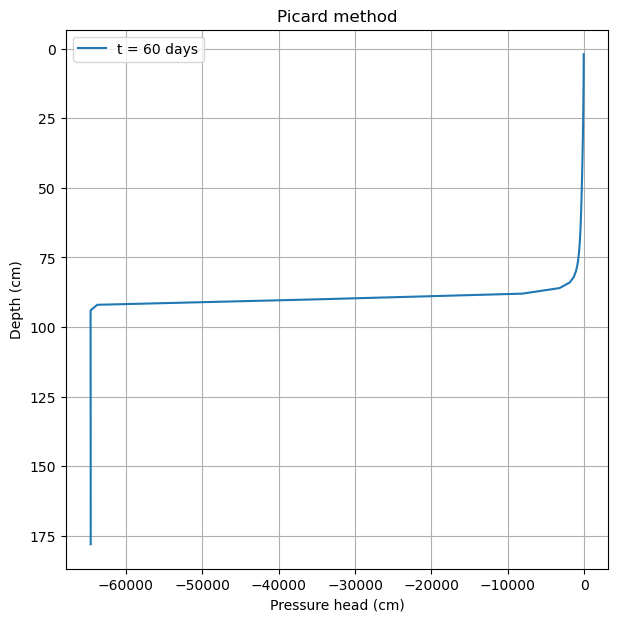

In [ ]:
#Single profile plot (60 days)

# Modify z to represent depth
plt.figure(figsize=(7, 7))  # Set figure size (square)
z_depth = np.flip(z)  # Flip z so depth increases downward

psi_plot = plt.plot(psi[59], z_depth, label='t = 60 days')  # Plot ψ vs depth at final time step

plt.xlabel('Pressure head (cm)')
plt.ylabel('Depth (cm)')
plt.gca().invert_yaxis()  # Invert y-axis for proper depth display
plt.title('Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

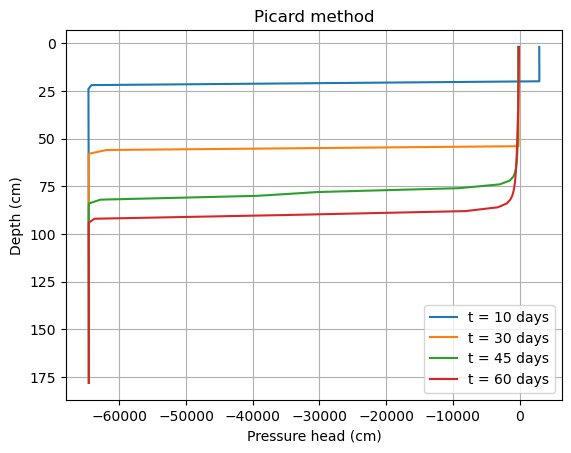

In [ ]:
# Multiple profile plots (t = 10, 30, 45, 60 days)

# Specify the time steps you want to plot
time_steps = [9, 29, 44, 59]  # Adjusted for zero-indexing (t = 10, 30, 45, 60 days)

# Loop through the specified time steps
for t in time_steps:
    plt.plot(psi[t], z_depth, label=f't = {t+1} days')  # t+1 because of zero-indexing but your days start from 1

plt.xlabel('Pressure head (cm)')
plt.ylabel('Depth (cm)')
plt.gca().invert_yaxis()
plt.title('Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()